In [1]:
import torch
import os
import re
import sys
import cv2
from config_reader import config_reader
import util
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

In [2]:
from PoseEstimator import PoseEstimation

In [3]:
torch_device = torch.device('cuda:3')

In [84]:
model_mask = PoseEstimation.model(pretrained=True)
model_mask = model_mask.to(torch_device)
model_mask.float()
model_mask.eval();

In [85]:
img_path = './sample_image/i.png'
mask_path = './sample_image/m.png'

In [102]:
for param in model_mask.parameters():
    param.requires_grad = False

model_mask.model6_1[12] = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=1, stride=1, padding=0)

for param in model_mask.model6_1[12].parameters():
    param.requires_grad = True
    
for param in model_mask.model6_1[10].parameters():
    param.requires_grad = True

model_mask = model_mask.to(torch_device)
model_mask.train();

In [103]:
param_, model_ = config_reader()

oriImg = cv2.imread(img_path) # B,G,R order
imageToTest = torch.FloatTensor(oriImg).permute((2,0,1))[None]
multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

heatmap_avg = torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])).to(torch_device)
paf_avg = torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])).to(torch_device)

scale = 1
h = int(oriImg.shape[0]*scale)
w = int(oriImg.shape[1]*scale)
pad_h = 0 if (h%model_['stride']==0) else model_['stride'] - (h % model_['stride']) 
pad_w = 0 if (w%model_['stride']==0) else model_['stride'] - (w % model_['stride'])
new_h = h + pad_h
new_w = w + pad_w

imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
imageToTest_padded = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5


feed = torch.Tensor(imageToTest_padded).to(torch_device)

output1, output2 = model_mask(feed)
print ('output1', output1.size())
print ('output2', output2.size())

output1 torch.Size([1, 2, 60, 80])
output2 torch.Size([1, 19, 60, 80])


In [104]:
mask = (plt.imread(mask_path)[:,:,0]>0.5).astype(np.uint8)
y = torch.LongTensor(mask).to(torch_device)
y.shape

torch.Size([480, 640])

In [105]:
feed.shape

torch.Size([1, 3, 480, 640])

In [106]:
loss = nn.CrossEntropyLoss()
loss = loss.to(torch_device)
grad_params = filter(lambda p: p.requires_grad, model_mask.parameters())
optimizer = torch.optim.Adam(grad_params,lr=0.01)

In [128]:
for epoch in range(100):
    losses = []
    prediction, _ = model_mask(feed)
    prediction = nn.Upsample((oriImg.shape[0], oriImg.shape[1]), mode='bilinear', align_corners=True)(prediction)      

    loss_batch = loss(prediction, y[None])
    losses.append(loss_batch.item())
    sys.stdout.write('\r epoch {0:}, loss {1:}'.format(epoch, losses[-1]))
    optimizer.zero_grad()
    loss_batch.backward()
    optimizer.step()

 epoch 99, loss 0.013226866722106934

In [129]:
prediction.shape

torch.Size([1, 2, 480, 640])

In [130]:
pred = nn.Softmax(dim=1)(prediction)[0,1].cpu().data.numpy()
pred.shape

(480, 640)

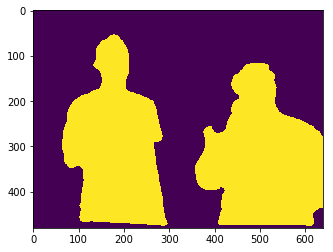

In [153]:
plt.imshow(pred>0.5)

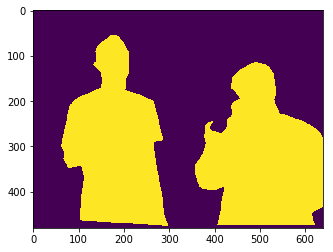

In [154]:
plt.imshow(y)

In [ ]:
cv2.imwrite('result.png', canvas)   

In [ ]:
plt.figure(figsize=(7,7))
b,g,r = cv2.split(canvas)
canvas_rgb = cv2.merge((r,g,b))
plt.imshow(canvas_rgb)